# Participant Prediction

In [1]:
%precision 3
%matplotlib inline

In [2]:
# Year to predict for
PREDICTION_YEAR = 2017

# Year to train prediction for
TRAINING_PREDICTION_YEAR = PREDICTION_YEAR - 1

# Percent of dataset to use for training
TRAINING_DATA_PERCENT = 0.70

# Available year range
MIN_YEAR = 2003
MAX_YEAR = 2016

## Preprocessing

In [3]:
import data
import pandas as pd

In [4]:
def get_recurring_runners_from(df, curr_year, target_year):
    return df.loc[(df.year == target_year) & (df.years_since_run == target_year - curr_year)]


def set_participated_in_year(df, curr_year, target_year):
    next_df = get_recurring_runners_from(df, curr_year, target_year)
    recurring_ids = next_df.id.unique()
    df.loc[(df.year == curr_year) & (df.id.isin(recurring_ids)), "participated_in_year"] = True
    
    
def set_all_participated_in_year(df, target_year):
    df["participated_in_year"] = False
    for year in range(MIN_YEAR, target_year):
        set_participated_in_year(df, year, target_year)

In [5]:
raw_df = data.get_data()
df = pd.DataFrame()

df["id"] = raw_df["id"]
df["age"] = raw_df["age"].apply(lambda x: 5 * (x // 5))
df["male"] = raw_df["male"]
df["year"] = raw_df["year"]
df["run_count"] = raw_df["run_count"]
df["years_since_run"] = raw_df["years_since_run"].apply(lambda x: max(0, x))
df["ran_last_year"] = raw_df["years_since_run"].apply(lambda x: x == 1)
df["years_to_prediction"] = raw_df["year"].apply(lambda x: TRAINING_PREDICTION_YEAR - x)
df["time_in_seconds"] = raw_df["time_in_seconds"]
df["ignore"] = raw_df["ignore"]
set_all_participated_in_year(df, TRAINING_PREDICTION_YEAR)

all_df = df.copy()    

df = df.loc[df.ignore == False]
df = df.sample(frac=1)

In [6]:
df

,id,age,male,year,run_count,years_since_run,ran_last_year,years_to_prediction,time_in_seconds,ignore,participated_in_year
24359,17181,20,1,2010,0,0,False,6,18848.0,False,False
19091,13001,45,1,2008,0,0,False,8,15697.0,False,False
30809,22772,35,0,2012,0,0,False,4,10212.0,False,False
8578,5010,25,0,2004,0,0,False,12,17593.0,False,False
10938,6642,25,1,2005,0,0,False,11,14215.0,False,False
16441,10875,40,1,2007,0,0,False,9,14914.0,False,False
14257,9182,35,1,2006,0,0,False,10,14531.0,False,False
32692,24538,20,0,2013,0,0,False,3,14978.0,False,False
31762,23666,40,1,2013,0,0,False,3,14386.0,False,False
17528,11757,25,1,2008,0,0,False,8,17853.0,False,False


## Splitting data

In [7]:
import numpy as np

In [8]:
def get_nb_inputs(df):
    return df[["age", "male", "run_count", "years_since_run", "years_to_prediction"]]


def get_reg_inputs(df):
    return df[["age", "male", "run_count", "years_since_run", "time_in_seconds"]]


def get_outputs(df):
    return df["participated_in_year"]


def count(df):
    return df.count().id

In [9]:
dataset = df[df.year < TRAINING_PREDICTION_YEAR]
training_mask = np.random.rand(len(dataset)) < TRAINING_DATA_PERCENT
training = dataset[training_mask]
testing = dataset[~training_mask]

training_nb_inputs = get_nb_inputs(training)
training_reg_inputs = get_reg_inputs(training)
training_outputs = get_outputs(training)

testing_nb_inputs = get_nb_inputs(testing)
testing_reg_inputs = get_reg_inputs(testing)
testing_outputs = get_outputs(testing)

In [10]:
training_positives = count(training[training.participated_in_year])
training_total = count(training)

testing_positives = count(testing[testing.participated_in_year])
testing_total = count(testing)

In [11]:
training_positives, training_total, training_positives / training_total

(561, 24780, 0.023)

In [12]:
testing_positives, testing_total, testing_positives / testing_total

(240, 10606, 0.023)

## Training

#### Bernoulli Naive Bayes

In [13]:
from sklearn.naive_bayes import BernoulliNB

In [14]:
bnb = BernoulliNB()
bnb = bnb.fit(training_nb_inputs, training_outputs)

In [15]:
bnb_predictions = bnb.predict(testing_nb_inputs)

#### Gaussian Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
gnb = GaussianNB()
gnb = gnb.fit(training_nb_inputs, training_outputs)

In [18]:
gnb_predictions = gnb.predict(testing_nb_inputs)

#### Multinomial Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
mnb = MultinomialNB()
mnb = mnb.fit(training_nb_inputs, training_outputs)

In [21]:
mnb_predictions = mnb.predict(testing_nb_inputs)

#### Custom Multinomial Naive Bayes

In [22]:
from naive_bayes import MultinomialNaiveBayes

In [23]:
custom_mnb = MultinomialNaiveBayes()
custom_mnb.fit(training_nb_inputs.as_matrix(), training_outputs.as_matrix())

In [24]:
custom_mnb_predictions = custom_mnb.predict(testing_nb_inputs.as_matrix())

#### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
reg = LogisticRegression()
reg = reg.fit(training_reg_inputs, training_outputs)

In [27]:
reg_predictions = reg.predict(testing_reg_inputs)

## Testing

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [29]:
_ = np.seterr(divide="ignore", invalid="ignore")

In [30]:
def get_confusion_matrix_as_df(c_matrix):
    confusion_df = pd.DataFrame(c_matrix,
                                index=["N", "Y"],
                                columns=["N", "Y"])

    percent_df = confusion_df.applymap(lambda x: x / c_matrix.sum())

    return confusion_df, percent_df


def plot_confusion_matrix(confusion, percent):
    fig, axs = plt.subplots(nrows=2, sharex=True)
    sns.heatmap(confusion, annot=True, fmt="d", ax=axs[0])
    sns.heatmap(percent, annot=True, ax=axs[1])

    
def score(c_matrix):
    TN = c_matrix[0, 0]
    FN = c_matrix[1, 0]
    TP = c_matrix[1, 1]
    FP = c_matrix[0, 1]

    accuracy = (TN + TP) / c_matrix.sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (FP + TN)
    false_positive_rate = FP / (FP + TN)
    f1_measure = 2 * (precision * recall) / (precision + recall)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "false_positive_rate": false_positive_rate,
        "f1_measure": f1_measure
    }


def measure(predictions, truth):
    c_matrix = confusion_matrix(truth, predictions)
    plot_confusion_matrix(*get_confusion_matrix_as_df(c_matrix))
    return score(c_matrix)

#### Expected Distribution

{'accuracy': 1.000,
 'f1_measure': 1.000,
 'false_positive_rate': 0.000,
 'precision': 1.000,
 'recall': 1.000,
 'specificity': 1.000}

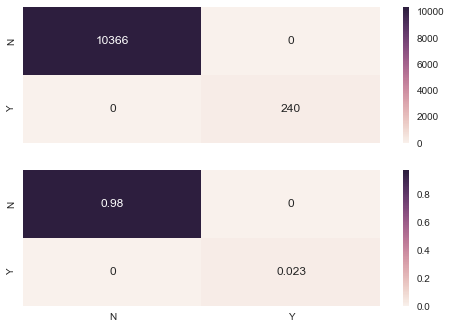

In [31]:
measure(testing_outputs, testing_outputs)

#### Bernouilli Naive Bayes

{'accuracy': 0.977,
 'f1_measure': nan,
 'false_positive_rate': 0.000,
 'precision': nan,
 'recall': 0.000,
 'specificity': 1.000}

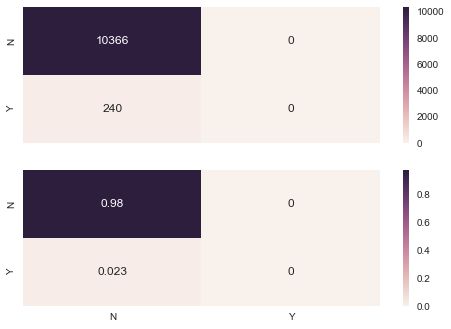

In [ ]:
measure(bnb_predictions, testing_outputs)

#### Gaussian Naive Bayes

In [ ]:
measure(gnb_predictions, testing_outputs)

{'accuracy': 0.945,
 'f1_measure': 0.138,
 'false_positive_rate': 0.038,
 'precision': 0.107,
 'recall': 0.196,
 'specificity': 0.962}

#### Multinomial Naive Bayes

In [ ]:
measure(mnb_predictions, testing_outputs)

#### Custom Multinomial Naive Bayes

In [ ]:
measure(custom_mnb_predictions, testing_outputs)

#### Logistic Regression

In [ ]:
measure(reg_predictions, testing_outputs)

## Future Prediction

In [ ]:
prediction_df = all_df.copy().sort_values(by=["id", "year"])
prediction_df["years_to_prediction"] = all_df["year"].apply(lambda x: PREDICTION_YEAR - x)

set_all_participated_in_year(prediction_df, PREDICTION_YEAR)

prediction_df = prediction_df[prediction_df.year < PREDICTION_YEAR]
prediction_df.drop_duplicates(keep="last", subset="id", inplace=True)

In [ ]:
prediction_nb_inputs = get_nb_inputs(prediction_df)
prediction_reg_inputs = get_reg_inputs(prediction_df)

prediction_outputs = get_outputs(prediction_df)

In [ ]:
bnb_predictions = bnb.predict(prediction_nb_inputs)
gnb_predictions = gnb.predict(prediction_nb_inputs)
mnb_predictions = mnb.predict(prediction_nb_inputs)
custom_mnb_predictions = custom_mnb.predict(prediction_nb_inputs.as_matrix())
reg_predictions = reg.predict(prediction_reg_inputs)

In [ ]:
total = count(prediction_df)
[
    sum(bnb_predictions) / total,
    sum(gnb_predictions) / total,
    sum(mnb_predictions) / total,
    sum(custom_mnb_predictions) / total,
    sum(reg_predictions) / total    
]

### Metrics

*Ignore score if no data is available for the prediction year.*

#### Expected Distribution

In [ ]:
if PREDICTION_YEAR <= MAX_YEAR:
    measure(prediction_outputs, prediction_outputs)

#### Bernouilli Naive Bayes

In [ ]:
measure(bnb_predictions, prediction_outputs)

#### Gaussian Naive Bayes

In [ ]:
measure(gnb_predictions, prediction_outputs)

#### Multinomial Naive Bayes

In [ ]:
measure(mnb_predictions, prediction_outputs)

#### Custom Multinomial Naive Bayes

In [ ]:
measure(custom_mnb_predictions, prediction_outputs)

#### Logistic Regression

In [ ]:
measure(reg_predictions, prediction_outputs)

## Output

In [ ]:
def to_dataframe(pred):
    data = np.vstack([prediction_df.id.as_matrix(), pred]).T
    return pd.DataFrame(data, columns=["id", "y"])

prediction_only = to_dataframe(custom_mnb_predictions)
prediction_df["y"] = prediction_only["y"].as_matrix()

In [ ]:
if PREDICTION_YEAR > MAX_YEAR:
    prediction_only.to_csv("naive_bayes_prediction.csv", index=False, header=False)

# Previous years comparison

In [ ]:
year_on_year = []
for year in range(MIN_YEAR + 1, PREDICTION_YEAR):
    total = count(df[df.year == year])
    newbies = count(df[(df.year == year) & (df.run_count == 0)])
    oldies = total - newbies
    year_on_year.append([year, newbies, oldies, total, oldies / total])

year_on_year_df = pd.DataFrame(year_on_year,
                               columns=["year", "new", "returning", "total", "returning rate"])

In [ ]:
year_on_year_df